In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import mlflow
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, BayesianRidge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope
from sklearn.compose import ColumnTransformer


import warnings

warnings.filterwarnings('ignore')


KeyboardInterrupt



# Configs and Variables

In [ ]:
MLFLOW_TRACKING_URI = 'http://127.0.0.1:5000'

mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
mlflow.set_experiment('portugal-rent-price')

In [2]:
DATA_PATH = '../data/processed/data.parquet'

# Functions

In [3]:
def read_dataset(filename: str) -> pd.DataFrame:
    df = pd.read_parquet(filename)
    
    df['property_ads'] = df.company.apply(lambda x: 'private' if x == 'Anúncio Particular' else 'private')
    
    # Generate val_data
    train, val = train_test_split(df,  test_size=.3, train_size=.7, random_state=42)
    
    return (train, val)

In [4]:
def one_hot_encode(data, column, encoder):
    encoded = encoder.transform(data[column])
    ohe_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out())
    #concat with original data
    data = pd.concat([data, ohe_df], axis=1).drop(column, axis=1)

    return data

# Load Data

In [5]:
# train, val = read_dataset(DATA_PATH)

In [6]:
# train.reset_index(inplace=True, drop=True)
# val.reset_index(inplace=True, drop=True)

In [7]:
train = pd.read_parquet('../data/processed/train.parquet')
val = pd.read_parquet('../data/processed/val.parquet')

In [8]:
X_train = train.drop('price', axis=1)
y_train = train['price']
X_val = val.drop('price', axis=1)
y_val = val['price']

In [9]:
X_train.isna().sum().sum()

0

In [10]:
X_val.isna().sum().sum()

0

In [11]:
print('Train dataset:', X_train.shape)
print('Val dataset:', X_val.shape)

Train dataset: (2177, 10)
Val dataset: (933, 10)


In [12]:
X_train.drop(['description', 'company', 'location'], inplace=True, axis=1)
X_val.drop(['description', 'company', 'location'], inplace=True, axis=1)

# Preparing Data

In [13]:
property_map = {'apartamento': 0, 'moradia': 1}
X_train['property_type'] = X_train['property_type'].map(property_map)
X_val['property_type'] = X_val['property_type'].map(property_map)

In [14]:
def preprocess_data(df_train: pd.DataFrame, df_val: pd.DataFrame):

    property_map = {'apartamento': 0, 'moradia': 1}
    numerical_columns = ['metric', 'rooms', 'bathroom']
    categorical_columns = ['energy_certify',
                           'property_type', 'district', 'condition']

    preprocessor = ColumnTransformer(
        transformers=[
            ('onehot', OneHotEncoder(drop='first',
             handle_unknown='ignore'), categorical_columns),
            ('scaler', StandardScaler(), numerical_columns)
        ]
    )
    X_train = df_train.drop(['price'], axis=1)
    X_train['property_type'] = X_train['property_type'].map(property_map)

    X_val = df_val.drop(['price'], axis=1)
    X_val['property_type'] = X_val['property_type'].map(property_map)

    y_train = df_train['price']
    y_val = df_val['price']

    X_train_processed = preprocessor.fit_transform(X_train)
    X_val_processed = preprocessor.transform(X_val)

    return (X_train_processed, X_val_processed, y_train, y_val, preprocessor)

X_train_processed, X_val_processed, y_train, y_val, preprocessor = preprocess_data(train, val)

E:\Estudos\Projetos\Python\mlops_final_project\.venv\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


# Start Run Models

In [21]:
models = {
    'ridge' : Ridge(),
    'xgboost' : xgb.XGBRegressor(),
    'gradient boosting' : GradientBoostingRegressor(),
    'lasso' : Lasso(),
    'random forest' : RandomForestRegressor(),
    'bayesian ridge' : BayesianRidge(),
    'support vector': SVR(),
    'linear regressor': LinearRegression(),
    'knn' : KNeighborsRegressor(n_neighbors = 4)
}

In [22]:
for name, model in models.items():

    with mlflow.start_run():
        mlflow.set_tag('features', 'filter_rooms')
        mlflow.set_tag('developer', 'marcospereira')
        mlflow.log_param('numeric_columns', numb_columns)
        mlflow.log_param('categorical_columns', cat_columns)


        mlflow.set_tag('model', name)
        print(f'Training the model: {name}')
        model.fit(X_train_f, y_train)

        y_pred = model.predict(X_val_f)

        rmse = mean_squared_error(y_val, y_pred, squared=False)
        r2 = r2_score(y_val, y_pred)
        mlflow.log_metric('rmse', rmse)
        mlflow.log_metric('r2', r2)
    


Training the model: ridge
Training the model: xgboost
Training the model: gradient boosting
Training the model: lasso
Training the model: random forest
Training the model: bayesian ridge
Training the model: support vector
Training the model: linear regressor
Training the model: knn


In [29]:
for name, model in models.items():

    with mlflow.start_run():
        mlflow.set_tag('features', 'filter_rooms')
        mlflow.set_tag('developer', 'marcospereira')
        mlflow.log_param('numeric_columns', numb_columns)
        mlflow.log_param('categorical_columns', cat_columns)


        mlflow.set_tag('model', name)
        print(f'Training the model: {name}')
        if name != 'bayesian ridge':
            model.fit(X_train_processed, y_train)
            y_pred = model.predict(X_val_processed)
        else:
            model.fit(X_train_processed.toarray(), y_train)
            y_pred = model.predict(X_val_processed.toarray())

        

        rmse = mean_squared_error(y_val, y_pred, squared=False)
        r2 = r2_score(y_val, y_pred)
        mlflow.log_metric('rmse', rmse)
        mlflow.log_metric('r2', r2)
    


Training the model: ridge
Training the model: xgboost
Training the model: gradient boosting
Training the model: lasso
Training the model: random forest
Training the model: bayesian ridge
Training the model: support vector
Training the model: linear regressor
Training the model: knn


In [15]:
model = xgb.XGBRegressor()
model.fit(X_train_processed, y_train)

y_pred = model.predict(X_val_processed)

rmse = mean_squared_error(y_val, y_pred, squared=False)
r2 = r2_score(y_val, y_pred)

In [16]:
print(rmse)
print(r2)

1211.7854998648304
0.6372367369620702


In [76]:
model.get_params()

{'objective': 'reg:squarederror',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'gpu_id': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [45]:
from pycaret.regression import *

In [46]:
data = X_train.copy()
data['Price'] = y_train

In [47]:
data.drop(['description', 'company', 'location'], inplace=True, axis=1)

In [49]:
data

,energy_certify,metric,rooms,property_type,district,bathroom,condition,Price
0,D,30.03,1,apartamento,Porto,1.0,Usado,1000
1,C,114.00,2,apartamento,Lisboa,3.0,Renovado,1950
2,D,90.00,2,apartamento,Faro,1.0,Usado,550
3,C,85.00,2,apartamento,Lisboa,2.0,Usado,1550
4,C,100.00,3,apartamento,Braga,1.0,Novo,900
...,...,...,...,...,...,...,...,...
2172,A,100.00,3,apartamento,Vila Real,2.0,Usado,600
2173,C,108.00,2,apartamento,Lisboa,2.0,Renovado,3000
2174,D,85.00,3,apartamento,Lisboa,2.0,Renovado,3500
2175,C,98.00,3,apartamento,Lisboa,2.0,Renovado,1900


In [48]:
s = setup(data, target='Price', transform_target=True)

,Description,Value
0,Session id,5783
1,Target,Price
2,Target type,Regression
3,Original data shape,"(2177, 8)"
4,Transformed data shape,"(2177, 41)"
5,Transformed train set shape,"(1523, 41)"
6,Transformed test set shape,"(654, 41)"
7,Ordinal features,1
8,Numeric features,3
9,Categorical features,4


In [27]:
best = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
xgboost,Extreme Gradient Boosting,508.9871,859935.1005,911.1140,0.6928,0.3886,0.3177,0.1110
lightgbm,Light Gradient Boosting Machine,510.9619,898259.0426,926.4543,0.6862,0.3902,0.3196,0.0870
et,Extra Trees Regressor,521.7096,893173.6853,927.9339,0.6842,0.3973,0.3337,0.1370
gbr,Gradient Boosting Regressor,515.4264,942157.2889,944.0790,0.6774,0.3860,0.3173,0.1010
rf,Random Forest Regressor,524.6662,945002.8015,947.8781,0.6739,0.4018,0.3326,0.1370
ridge,Ridge Regression,527.9999,965958.0938,963.7854,0.6593,0.3598,0.2861,0.0740
br,Bayesian Ridge,541.7035,1049079.0781,1000.3505,0.6335,0.3609,0.2882,0.0740
lr,Linear Regression,553.5952,1133669.3067,1037.3726,0.6067,0.3632,0.2908,0.2560
huber,Huber Regressor,553.6198,1131870.8184,1038.2797,0.6020,0.3713,0.2969,0.0750
ada,AdaBoost Regressor,620.0689,1261549.3514,1099.3655,0.5639,0.4593,0.4003,0.0820


In [28]:
plot_model(best, plot = 'residuals_interactive')


    'data': [{'hovertemplate': 'Split=train<br>Predictions…

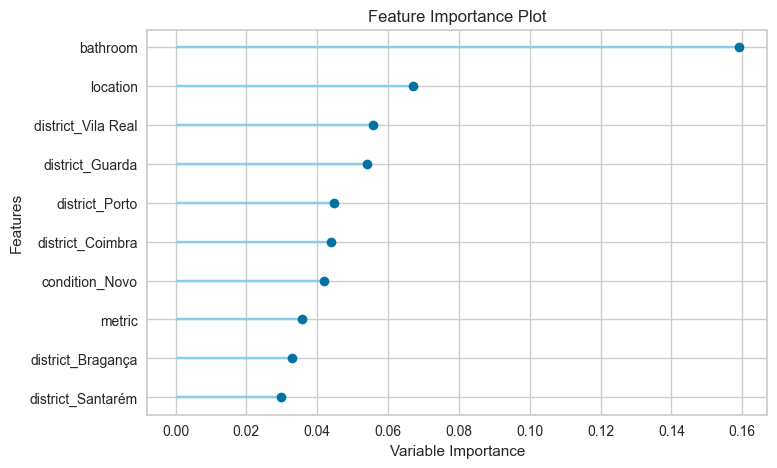

In [29]:
plot_model(best, plot = 'feature')


In [30]:
# finalize the model
final_best = finalize_model(best)

In [31]:
final_best

Pipeline(memory=FastMemory(location=C:\Users\MARCOS~1\AppData\Local\Temp\joblib),
         steps=[('target_transformation',
                 TransformerWrapperWithInverse(transformer=TargetTransformer(estimator=PowerTransformer(standardize=False)))),
                ('numerical_imputer',
                 TransformerWrapper(include=['metric', 'rooms', 'bathroom'],
                                    transformer=SimpleImputer())),
                ('categorical_impute...
                              feature_types=None, gamma=None, gpu_id=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=100,
                              n_jobs=-1, num_parallel_tree=None, predictor=None,
                              random_state=7282, ...))])

In [33]:
X_val

,energy_certify,metric,description,location,rooms,company,property_type,district,bathroom,condition
0,D,30.03,Apartamento T1 para Arrendamento à Casa da Música,"Lordelo do Ouro e Massarelos, Porto",1,Frontal Imobiliaria,apartamento,Porto,1.0,Usado
1,C,114.00,Apartamento T2 - Jardins da Parede.,"Carcavelos e Parede, Cascais, Lisboa",2,La Vita - Homes -,apartamento,Lisboa,3.0,Renovado
2,D,90.00,Apartamento T2 em Tavira - Centro,"Luz de Tavira e Santo Estêvão, Tavira, Faro",2,OLX,apartamento,Faro,1.0,Usado
3,C,85.00,Apartamento para alugar com 2 quartos (3 assoa...,"Oeiras e São Julião da Barra, Paço de Arcos e ...",2,"AbelhaZ - Mediação Imobiliária Unip., Lda",apartamento,Lisboa,2.0,Usado
4,C,100.00,Apartamento T3 em Esposende para arrendar,"Esposende, Marinhas e Gandra, Esposende, Braga",3,GLOBODOMINANTE Soluções Imobiliárias,apartamento,Braga,1.0,Novo
...,...,...,...,...,...,...,...,...,...,...
2172,A,100.00,Arrendo apartamento T3,"Vila Real (Nossa Senhora da Conceição, São Ped...",3,OLX,apartamento,Vila Real,2.0,Usado
2173,C,108.00,"APARTMENT T2, AVENIDA INFANTE SANTO, ESTRELA,...","Estrela, Lisboa",2,KW LEAD,apartamento,Lisboa,2.0,Renovado
2174,D,85.00,Apartamento T3 com Jardim Exclusivo e Possibil...,"Cascais e Estoril, Cascais, Lisboa",3,"AFINEST - Abreu Faro - Mediação Imobiliária, Lda.",apartamento,Lisboa,2.0,Renovado
2175,C,98.00,"Apartamento T3, REMODELADO, junto ao Jardim da...","Estrela, Lisboa",3,Home Tailors,apartamento,Lisboa,2.0,Renovado


In [35]:
y_pred = final_best.predict(X_val.drop(['description', 'company'], axis=1))

In [36]:
y_pred.isna().sum()

0

In [37]:
y_pred

0        966.428040
1       2286.099365
2        593.696838
3       1554.612549
4        966.778748
           ...     
2172     691.873108
2173    2729.788086
2174    3168.817871
2175    2445.641846
2176     856.957336
Name: Price, Length: 2177, dtype: float32

In [38]:
mean_squared_error(y_val, round(y_pred), squared=False)

317.3531351702526

In [39]:
y_val

0       1000
1       1950
2        550
3       1550
4        900
        ... 
2172     600
2173    3000
2174    3500
2175    1900
2176     900
Name: price, Length: 2177, dtype: int32

In [40]:
round(y_pred)

0        966.0
1       2286.0
2        594.0
3       1555.0
4        967.0
         ...  
2172     692.0
2173    2730.0
2174    3169.0
2175    2446.0
2176     857.0
Name: Price, Length: 2177, dtype: float32

In [41]:
r2_score(y_val, round(y_pred))

0.9660404798968676

In [ ]:
# https://towardsdatascience.com/easy-mlops-with-pycaret-mlflow-7fbcbf1e38c6